In [1]:
import random
import torch
import pandas as pd
import numpy as np
import json
from torch import nn
from torch.optim import AdamW, Adam
from transformers import AutoModel, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification
from transformers import RobertaForSequenceClassification
from transformers import RobertaModel
from transformers import get_scheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import metrics as metrics
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import re
from nltk.tokenize import sent_tokenize

random.seed(42)
reprocess_raw =  False

batch_size = 10 # documents
learning_rate = 5e-5
n_epochs = 10

# task_map = {'Quantity':1}
task_map = {'Quantity':1,'MeasuredProperty':2,'MeasuredEntity':3,'Qualifier':4} # uncomment for multi-class
num_classes = len(task_map)

model_name = 'allenai/biomed_roberta_base'
# model_name = 'bert-base-cased'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = 'cpu' # uncomment this to make debugging easier

data_size_reduce = 1 # multiplier for making small datasets



In [2]:
currentdir = os.getcwd() # ~/MeasEval/baselines

combopath_txt = os.path.join(currentdir, "../data/raw/combo/text/")
combopath_annot = os.path.join(currentdir, "../data/raw/combo/tsv/")

interimpath = os.path.join(currentdir, "../data/interim/")

In [3]:
def process_raw_txt(docs):
    processesd_txt = {}
    remove_markers = True

    cnt_toks = {"figs.": 0, "fig.": 0, "et al.": 0,
            "ref.": 0, "eq.": 0, "e.g.": 0,
            "i.e.": 0, "nos.": 0, "no.": 0,
            "spp.": 0
            }
    regex_end_checker = [".*[a-zA-Z]figs\.$", 
                        ".*[a-zA-Z]fig\.$",
                        ".*[a-zA-Z]et al\.$",
                        ".*[a-zA-Z]ref\.$",
                        ".*[a-zA-Z]eq\.$",
                        ".*[a-zA-Z]e\.g\.$",
                        ".*[a-zA-Z]i\.e\.$",
                        ".*[a-zA-Z]nos\.$",
                        ".*[a-zA-Z]no\.$",
                        ".*[a-zA-Z]spp\.$",
                        # figs., fig., et al., Ref., Eq., e.g., i.e., Nos., No., spp.
                    ]

    assert len(cnt_toks) == len(regex_end_checker)

    for docId, doc in docs.items():
        flag = False
        sentences = sent_tokenize(doc)

        fixed_sentence_tokens = []
        curr_len = 0
        for s in sentences:
            if flag == True:
                assert s[0] != ' '
                white_length = doc[curr_len:].find(s[0])

                prev_len = len(fixed_sentence_tokens[-1])
                fixed_sentence_tokens[-1] = fixed_sentence_tokens[-1] + (" "*white_length) + s

                assert fixed_sentence_tokens[-1][prev_len+white_length] == doc[curr_len+white_length], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                tmp_this_sent_len = white_length + len(s)
                assert fixed_sentence_tokens[-1][-1] == doc[curr_len+tmp_this_sent_len-1], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                curr_len += tmp_this_sent_len
            else:
                if len(fixed_sentence_tokens) != 0:
                    assert s[0] != ' '
                    white_length = doc[curr_len:].find(s[0])
                    fixed_sentence_tokens.append( (" "*white_length) + s )
                else:
                    fixed_sentence_tokens.append(s)
                assert fixed_sentence_tokens[-1][0] == doc[curr_len], (fixed_sentence_tokens, doc, curr_len, tmp_this_sent_len)
                tmp_this_sent_len = len(fixed_sentence_tokens[-1])
                assert fixed_sentence_tokens[-1][-1] == doc[curr_len+tmp_this_sent_len-1], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                curr_len += tmp_this_sent_len

            lower_cased_s = fixed_sentence_tokens[-1].lower()
            flag = False
            if remove_markers:
                for i, k in enumerate(cnt_toks):
                    this_regex_pattern = regex_end_checker[i]
                    if lower_cased_s.endswith(k) and re.match(this_regex_pattern, lower_cased_s) == None:
                        cnt_toks[k] += 1
                        flag = True
                        break

        processesd_txt[docId] = ''.join(fixed_sentence_tokens)
    return processesd_txt


In [4]:
def read_data(reprocess_raw = False):

    if reprocess_raw == True:
        docIds = []
        combo_txt = {}
        for fn in os.listdir(combopath_txt):
            docIds.append(fn[:-4])
            path = combopath_txt+fn
            with open(path) as textfile:
                    text = textfile.read()
                    #[:-4] strips off the .txt to get the id
                    combo_txt[fn[:-4]] = text

        combo_annot = pd.DataFrame()
        for fn in os.listdir(combopath_annot):
            path = combopath_annot+fn
            file = pd.read_csv(path,delimiter='\t',encoding='utf-8')
            combo_annot = pd.concat([combo_annot, file],ignore_index=True)

        combo_txt = process_raw_txt(combo_txt)
        assert docIds == list(combo_txt.keys()), (len(docIds), len(list(combo_txt.keys())))

        with open(interimpath+'combo_txt.json','w') as f:
            json.dump(combo_txt, f)

        combo_annot.to_csv(interimpath+'combo_annot.csv')

        return docIds, combo_txt, combo_annot
    else:
        combo_annot = pd.read_csv(interimpath+'combo_annot.csv')

        with open(interimpath+'combo_txt.json','r') as f:
            combo_txt = json.load(f)

        docIds = list(combo_txt.keys())
    
        return docIds, combo_txt, combo_annot

In [5]:
combo_docs, combo_txt, combo_annot = read_data(reprocess_raw = reprocess_raw)

In [6]:
#### train/dev/test split options

random.seed(42)

percent_to_test = .1
percent_to_dev = .2
percent_to_train =  1 - percent_to_dev - percent_to_test

n_doc = len(combo_docs)
split_train = int(np.round(n_doc * percent_to_train))
split_dev = split_train + int(np.round(n_doc * percent_to_dev))

train_docs = combo_docs[:split_train]
dev_docs = combo_docs[split_train:split_dev]
test_docs = combo_docs[split_dev:]

train_docs = random.sample(train_docs, int(len(train_docs)*data_size_reduce))
dev_docs = random.sample(dev_docs, int(len(dev_docs)*data_size_reduce))
test_docs = random.sample(test_docs, int(len(test_docs)*data_size_reduce))

In [7]:
########## Tokenizer ###########

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
def process_annotation_set(annot_set):

    annot_set_processed = []

    annot_set['comboIds'] = annot_set[['docId','annotId']].agg('_'.join, axis=1)
    annot_set.set_index('comboIds',inplace=True)

    for comboId in list(annot_set.index):
        
        docId = annot_set.loc[comboId]['docId']
        annotId = annot_set.loc[comboId]['annotId']

        annotType = annot_set.loc[comboId]['annotType']
        annotSpan = [annot_set.loc[comboId]['startOffset'],annot_set.loc[comboId]['endOffset']]

        ent_annot_processed = {
            'comboId':comboId,
            'docId':docId,
            'annotId':annotId,
            'annotType':annotType,
            'annotSpan':annotSpan,
            'subSpanType':np.nan,
            'linkId':np.nan,
            'linkSpan':np.nan,
            'subSpan':np.nan,
            'unit':np.nan,
            'unitEncoded':np.nan,
            'misc':np.nan
        }
        
        other = annot_set.loc[comboId]['other']
        if isinstance(other,str):
            otherDict = json.loads(str(other))

            if annot_set.loc[comboId]['annotType'] != 'Quantity':

                ent_annot_processed['subSpanType'] = list(otherDict.keys())[0]
                link = list(otherDict.values())[0]

                ent_annot_processed['linkId'] = link
                linkIdx = docId+'_'+link
                linkSpan = [int(annot_set.loc[linkIdx]['startOffset']),int(annot_set.loc[linkIdx]['endOffset'])]
                ent_annot_processed['linkSpan'] = linkSpan

                spanEnds = annotSpan + linkSpan
                ent_annot_processed['subSpan'] = [min(spanEnds),max(spanEnds)]

            elif 'unit' in list(otherDict.keys()):
                unit = otherDict['unit']
                ent_annot_processed['unit'] = unit
                ent_annot_processed['unitEncoded'] = tokenizer.encode(unit)[1:-1]
            else:
                ent_annot_processed['misc'] = otherDict


        annot_set_processed.append(ent_annot_processed)
   
    return pd.DataFrame.from_dict(annot_set_processed).set_index('comboId')

combo_annot_processed = process_annotation_set(combo_annot)
combo_annot_processed.to_csv(interimpath+'combo_annot_processed.csv')
combo_annot_processed.sample(7)


,docId,annotId,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,
S0019103512003995-1910_T1-2,S0019103512003995-1910,T1-2,MeasuredEntity,"[80, 102]",HasQuantity,T102-2,"[141, 162]","[80, 162]",NaN,NaN,NaN
S0378383912000130-3891_T3-2,S0378383912000130-3891,T3-2,MeasuredProperty,"[150, 158]",HasQuantity,T2-2,"[132, 149]","[132, 158]",NaN,NaN,NaN
S0012821X12004384-1178_T4-1,S0012821X12004384-1178,T4-1,Qualifier,"[108, 111]",Qualifies,T1-1,"[100, 107]","[100, 111]",NaN,NaN,NaN
S0019103512003995-1237_T5-2,S0019103512003995-1237,T5-2,Qualifier,"[292, 308]",Qualifies,T3-2,"[258, 275]","[258, 308]",NaN,NaN,NaN
S0016236113008041-3269_T2310-10,S0016236113008041-3269,T2310-10,Qualifier,"[1017, 1040]",Qualifies,T1510-10,"[989, 992]","[989, 1040]",NaN,NaN,NaN
S0012821X12004384-1594_T62-2,S0012821X12004384-1594,T62-2,Quantity,"[310, 314]",NaN,NaN,NaN,NaN,°N,"[12938, 487]",NaN
S0019103513005058-3094_T154-4,S0019103513005058-3094,T154-4,MeasuredEntity,"[1000, 1004]",HasProperty,T144-4,"[1041, 1046]","[1000, 1046]",NaN,NaN,NaN


In [9]:
### insert special tokens for subspans (Sam)
# will make docs longer

# def char_map(doc_annot, task_map)


def tokenize_and_align_labels(
                                doc_list=combo_docs,
                                txt=combo_txt,
                                processed_annotation=combo_annot_processed,
                                tokenizer=tokenizer,
                                taskLabelMap=task_map
                            ):

    toks_with_labels = []
    special_ids = tokenizer.all_special_ids

    for doc in doc_list:
        # print(doc)
        # print(processed_annotation.loc[processed_annotation['docId'] == doc])
        doc_annot = processed_annotation.loc[processed_annotation['docId'] == doc]
        doc_annot.set_index('annotId',inplace=True)
        # print(doc_annot)

        encoded_txt = tokenizer(txt[doc], padding='max_length', max_length=512, truncation=True)
        encoded_tokens = encoded_txt['input_ids']
        # print(encoded_tokens)

        ############### Label Primary Spans ###############

        labelIds = np.full(len(encoded_tokens),-1)
        taskCharMap = {} # 
        taskCharList = []
        taskAnnotIdCharMap = {} # to check for token collision
        
        for task in list(taskLabelMap.keys()):
            #print(task)
            annotId = doc_annot.loc[doc_annot['annotType']==task].index
            # print(annotId)
            spans = list(doc_annot.loc[doc_annot['annotType']==task]['annotSpan'])
            # print(spans)
            for span in spans:
                # print(span)
                span = list(range(span[0],span[-1]))
                # print(span)
                for spanCharIdx in span:
                    # print(spanCharIdx)
                    taskCharMap[spanCharIdx] = taskLabelMap[task]
                # print(taskCharMap)
                    # taskAnnotIdCharMap[spanCharIdx] = annotId

        decoded = [''] * len(encoded_tokens)
        for tokenIdx, token in enumerate(encoded_tokens):
            
            if token not in special_ids:
                tokenCharStart = encoded_txt.token_to_chars(tokenIdx).start
                if tokenCharStart in list(taskCharMap.keys()):
                    labelIds[tokenIdx] = taskCharMap[tokenCharStart]
                    decoded[tokenIdx] = tokenizer.decode(token)
                else:
                    labelIds[tokenIdx] = 0
            else:
                labelIds[tokenIdx] = 0
        

        ############### Sub Spans Token Insertion and labeling ###############

        encoded_txt['doc_or_sent_id'] = doc
        encoded_txt['labels'] = labelIds
        
        toks_with_labels.append(encoded_txt)
    
    # return toks_with_labels
    return pd.DataFrame.from_dict(toks_with_labels)

In [10]:
################# TOKENIZE #################

stage1_train_ds = tokenize_and_align_labels(
    doc_list=train_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_train_ds.to_csv(interimpath+'stage1_train_ds.csv')
stage1_n_train = stage1_train_ds.shape[0]


stage1_dev_ds = tokenize_and_align_labels(
    doc_list=dev_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_dev_ds.to_csv(interimpath+'stage1_dev_ds.csv')
stage1_n_dev = stage1_dev_ds.shape[0]

stage1_test_ds = tokenize_and_align_labels(
    doc_list=test_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_test_ds.to_csv(interimpath+'stage1_test_ds.csv')
stage1_n_test = stage1_test_ds.shape[0]


In [11]:
stage1_n_train

314

In [12]:
### Matt
# def shorten_txt_encoding(txt, shorten_by : int):       
#     pass...

# generate a list of docIds that have token collision after shortening

# toks = list(stage1_dev_ds.sample(1)['input_ids'])

# print(toks[0])

# tokenizer.decode(toks[0])

In [13]:
def batchify(tokenized_dataset, batch_size, device):
    num_examples = int(tokenized_dataset.shape[0] / batch_size)
    batch_sizes = [batch_size for x in range(num_examples)]
    last_batch_size = tokenized_dataset.shape[0] % batch_size
    if last_batch_size:
        batch_sizes.append(last_batch_size)
    # print(batch_sizes)

    batched_dataset = []

    idf_to_torch = lambda df : torch.tensor(np.array([list(map(int,r)) for r in df])).to(device)

    for idx, size in enumerate(batch_sizes):
        start = sum(batch_sizes[:idx])
        end = sum(batch_sizes[:idx]) + size - 1
        # print(start,end,idx)
        input_ids = idf_to_torch(tokenized_dataset['input_ids'].loc[start:end])
        attention_mask = idf_to_torch(tokenized_dataset['attention_mask'].loc[start:end])
        labels = idf_to_torch(tokenized_dataset['labels'].loc[start:end])
        doc_or_sent_id = list(tokenized_dataset['doc_or_sent_id'].loc[start:end])
        
        batch = {
            'input_ids':input_ids,
            'labels':labels,
            'attention_mask':attention_mask,
            'doc_or_sent_id':doc_or_sent_id

        }
        
        batched_dataset.append(batch)

    return batched_dataset

In [14]:
################# batchify ####################

batched_train_ds = batchify(stage1_train_ds[['attention_mask','input_ids','labels','doc_or_sent_id']], batch_size, device)
batched_dev_ds = batchify(stage1_dev_ds[['attention_mask','input_ids','labels','doc_or_sent_id']], batch_size, device)
batched_test_ds = batchify(stage1_test_ds[['attention_mask','input_ids','labels','doc_or_sent_id']], batch_size, device)


In [15]:
batched_train_ds[0]

{'input_ids': tensor([[    0, 44105,     4,  ...,     1,     1,     1],
         [    0,   970,    32,  ...,     1,     1,     1],
         [    0,   170,   220,  ...,     1,     1,     1],
         ...,
         [    0, 14699,    12,  ...,     1,     1,     1],
         [    0,   104, 40275,  ...,     1,     1,     1],
         [    0, 33837,  3024,  ...,     1,     1,     1]], device='cuda:0'),
 'labels': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 3, 3,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'doc_or_sent_id': ['S0016236113008041-3290',
  'S0006322312001096-1271',
  'S00220000

In [18]:
demo_batch = 2

demo_batch = batched_train_ds[demo_batch]


demo_doc = demo_batch['doc_or_sent_id'][0]
demo_ids = demo_batch['input_ids'].cpu().numpy()[0]
demo_tokens = tokenizer.decode(demo_batch['input_ids'].cpu().numpy()[0])
demo_labels = demo_batch['labels'].cpu().numpy()[0]
demo_mask = demo_batch['attention_mask'].cpu().numpy()[0]
latch_print = False
labeled_tokens = ''
for id, lab in zip(demo_ids, demo_labels):
    if lab:
        labeled_tokens = labeled_tokens + tokenizer.decode(id) + ' '

print(task_map)


{'Quantity': 1, 'MeasuredProperty': 2, 'MeasuredEntity': 3, 'Qualifier': 4}


In [19]:
demo_doc

'S0925443913001385-1646'

In [20]:
print(demo_ids)

[    0  1121   645     7  3094   549     5 18838  7205  1092 31425    67
 26914  1022    11 15229     8  6559     9     5 43261 14966   366 38868
   739     8   650  2849 46210     6 43261   784  2459  1626    31 43318
 19961  1001  3662 13651    36 40747     8   797    43    58 13484  1070
    15    16 36557 15557 43164 14170 12003 20676    36   698  2383   541
  4234    25    11  8526     4   646  3706 48610   318  6559     9  1169
     5   739  2849 19304    50     5  1445 14966   366  4399    21  2132
   172     5  3854     9  1736 14966   366 38868 17792    74   464   624
     5 43141  4392     4   374  1966 18838  7205  1092    31     5  3186
    21 12246  8065    11    70 44807    53 44012    11     5 44807  4292
    19 41601    12 10463   791   131   959    24    21 28840 11640    31
     5   481  3716    36   506 29866   112     8   132     6 20001     4
   195   322   152    21    11  5709     7     5   797    14 22495    10
  3716     9   481 18838  7205  1092     6    61   

In [21]:
print(demo_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2
 2 2 0 4 4 1 1 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [22]:
print(demo_tokens)

<s>In order to determine whether the MRPL12 mutation also induced changes in composition and assembly of the mitochondrial ribosomal large and small subunits, mitochondrial lysates from cultured fibroblasts (subject and control) were fractionated on isokinetic sucrose gradients (10–30%, as in Ref. [47]). If assembly of either the large subunit or the entire ribosome was affected then the distribution of individual ribosomal proteins would change within the gradient profile. On analysis MRPL12 from the patient was substantially decreased in all fractions but detectable in the fractions consistent with mt-LSU; however it was noticeably absent from the free pool (fractions 1 and 2, Fig. 5). This was in contrast to the control that exhibited a pool of free MRPL12, which has been reported to interact with POLRMT [56]. MRPL3 was also slightly reduced in subject cells but remained in fractions consistent with the large subunit. The MRPL12 mutation impacted more modestly on the small ribosomal

In [23]:
combo_annot_processed.loc[combo_annot['docId']==demo_doc]

,docId,annotId,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,
S0925443913001385-1646_T1-1,S0925443913001385-1646,T1-1,Quantity,"[277, 283]",NaN,NaN,NaN,NaN,%,[207],NaN
S0925443913001385-1646_T2-1,S0925443913001385-1646,T2-1,MeasuredEntity,"[247, 275]",HasQuantity,T1-1,"[277, 283]","[247, 283]",NaN,NaN,NaN
S0925443913001385-1646_T1-2,S0925443913001385-1646,T1-2,Quantity,"[1438, 1441]",NaN,NaN,NaN,NaN,%,[207],NaN
S0925443913001385-1646_T2-2,S0925443913001385-1646,T2-2,MeasuredProperty,"[1391, 1419]",HasQuantity,T1-2,"[1438, 1441]","[1391, 1441]",NaN,NaN,NaN
S0925443913001385-1646_T4-2,S0925443913001385-1646,T4-2,MeasuredEntity,"[1445, 1458]",HasProperty,T2-2,"[1391, 1419]","[1391, 1458]",NaN,NaN,NaN
S0925443913001385-1646_T3-2,S0925443913001385-1646,T3-2,Qualifier,"[1425, 1437]",Qualifies,T2-2,"[1391, 1419]","[1391, 1437]",NaN,NaN,NaN


In [24]:
print(labeled_tokens)

 is okin etic  suc rose  grad ients 10 – 30 %,  levels  in  the  subject  sample  decreased  to  63 %  control  value 


In [25]:
special_token_map = dict(zip(tokenizer.all_special_tokens,tokenizer.all_special_ids))
special_token_map

{'<s>': 0, '</s>': 2, '<unk>': 3, '<pad>': 1, '<mask>': 50264}

In [26]:
demo_annots = combo_annot_processed.loc[combo_annot['docId']==demo_doc]

demo_txt = combo_txt[demo_doc]

encoded_demo_txt = tokenizer(demo_txt, padding='max_length', max_length=512, truncation=True)
demo_token_startchar = []
for idx, id in enumerate(encoded_demo_txt['input_ids']):
    try: tokenCharStart = encoded_demo_txt.token_to_chars(idx).start
    except: tokenCharStart = np.nan
    demo_token_startchar.append(tokenCharStart)

subSpan_ds = {}
for comboId, annot in demo_annots.iterrows():
    if isinstance(annot['subSpanType'],float): continue # nans are floats
    print(comboId)
    print(annot['annotType'])
    print(annot['subSpanType'])
    print(annot['subSpan'][0],annot['subSpan'][1])
    subSpanRange = list(range(annot['subSpan'][0],annot['subSpan'][1]))
    # print(subSpanRange)
    subSpanIds = []
    subSpanLabels = []
    for id, label, startChar in zip(demo_ids, demo_labels, demo_token_startchar):
        if startChar in subSpanRange:
            subSpanIds.append(id)
            subSpanLabels.append(label)
    print(subSpanIds)
    print(subSpanLabels)
    print(tokenizer.decode(subSpanIds,skip_special_tokens=True))
    print()



S0925443913001385-1646_T2-1
MeasuredEntity
HasQuantity
247 283
[16, 36557, 15557, 43164, 14170, 12003, 20676, 36, 698, 2383, 541, 4234]
[3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 1]
 isokinetic sucrose gradients (10–30%,

S0925443913001385-1646_T2-2
MeasuredProperty
HasQuantity
1391 1441
[1389, 11, 5, 2087, 7728, 58, 8065, 7, 5549, 207]
[2, 2, 2, 2, 2, 0, 4, 4, 1, 1]
 levels in the subject sample were decreased to 63%

S0925443913001385-1646_T4-2
MeasuredEntity
HasProperty
1391 1458
[1389, 11, 5, 2087, 7728, 58, 8065, 7, 5549, 207, 9, 797, 923]
[2, 2, 2, 2, 2, 0, 4, 4, 1, 1, 0, 3, 3]
 levels in the subject sample were decreased to 63% of control value

S0925443913001385-1646_T3-2
Qualifier
Qualifies
1391 1437
[1389, 11, 5, 2087, 7728, 58, 8065, 7]
[2, 2, 2, 2, 2, 0, 4, 4]
 levels in the subject sample were decreased to



In [27]:
combo_txt[demo_doc][1391:1458]

'levels in the subject sample were decreased to 63% of control value'

In [28]:
class Stage1model(nn.Module):
    def __init__(self, dropout=0.1):
        super(Stage1model, self).__init__()
        self.mod = RobertaModel.from_pretrained(
                    model_name,
                    num_labels=num_classes+1,
                    hidden_dropout_prob=dropout,
                    output_hidden_states=True)
        self.norm = nn.BatchNorm1d(512, eps=self.mod.config.layer_norm_eps)
        self.drop = nn.Dropout(self.mod.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.mod.config.hidden_size, num_classes+1)

    def forward(self, input_ids, attention_mask):
        output = self.mod(input_ids=input_ids,attention_mask=attention_mask)
        y_hat = output.hidden_states[-1]
        y_hat = self.norm(y_hat)
        y_hat = self.drop(y_hat)
        y_hat = self.classifier(y_hat).permute(0,2,1)
        return y_hat

model = Stage1model().to(device)

model_new = model


Some weights of the model checkpoint at allenai/biomed_roberta_base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
model_new

Stage1model(
  (mod): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [30]:


# class OurBERTModel(nn.Module):
#     def __init__(self):
#         super(OurBERTModel, self).__init__()
#         self.mod = AutoModel.from_pretrained(model_name, num_labels=num_classes+1)
#         self.drop = nn.Dropout(self.mod.config.hidden_dropout_prob)
#         self.classifier = nn.Linear(self.mod.config.hidden_size, num_classes+1)

#     def forward(self, text, att_mask):
#         b, num_tokens = text.shape
#         token_type = torch.zeros((b, num_tokens), dtype=torch.long).to(device)
#         outputs = self.mod(text, attention_mask=att_mask, token_type_ids=token_type)
#         return self.classifier(self.drop(outputs['last_hidden_state']))

# model = OurBERTModel().to(device)

# model_old = model

In [31]:
# model_old

In [32]:
# demo_logits = model(demo_batch['input_ids'], demo_batch['attention_mask'])

In [33]:
# demo_logits.permute(0,2,1).shape

In [34]:
# demo_batch['labels'].shape

In [35]:
# ypred = []
# ytrue = []
# for dlabels, dlogits in zip(demo_batch['labels'], demo_logits.permute(0,2,1)):
#     print(dlabels.shape)
#     print(dlogits.shape)
#     for tlogits, tlabels in zip(dlogits, dlabels):
#         print(tlabels.shape)
#         print(tlogits.shape)
#         ypred.append(tlogits.argmax().item())
#         ytrue.append(tlabels.item())
#         print(ypred)
#         print(ytrue)
        

In [36]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = AdamW(model.parameters(), lr=learning_rate)

n_training_steps = n_epochs * len(batched_train_ds)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=n_training_steps
)


def train_epoch(ds, criterion):

    model.train()

    ypred = []
    ytrue = []
    for idx, batch in enumerate(ds):

        labels = batch['labels']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        
        optimizer.zero_grad()

        logits = model(input_ids, attention_mask)
        
        loss = criterion(logits, labels)
        # loss = (loss * attention_mask).sum() / (attention_mask).sum()
        
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        progress_bar.update(1)
            
    return loss.item()



def eval_epoch(ds, criterion):

    model.eval()

    ypred = []
    ytrue = []
    with torch.no_grad():
        for idx, batch in enumerate(ds):

            labels = batch['labels']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            logits = model(input_ids, attention_mask)
            
            loss = criterion(logits, labels)
            # loss = (loss * attention_mask).sum() / (attention_mask).sum()

            for dlogits, dlabels in zip(logits.permute(0,2,1), labels):
                    for tlogits, tlabels in zip(dlogits, dlabels):
                        ypred.append(tlogits.argmax().item())
                        ytrue.append(tlabels.item())

            progress_bar.update(1)

    acc = metrics.accuracy_score(ytrue,ypred)
    report = classification_report(ytrue,ypred,
                                    labels=list(task_map.values()),
                                    target_names=list(task_map.keys()),
                                    output_dict=True,
                                    zero_division=0)

                                    

    return loss.item(), acc, report, ytrue, ypred

In [37]:
run_report = {  'epoch':[],
                'train_loss':[],
                'eval_train_loss':[],
                'eval_train_acc':[],
                'eval_train_ytrue':[],
                'eval_train_ypred':[],
                'eval_train_rpt':[],
                'eval_dev_loss':[],
                'eval_dev_acc':[],
                'eval_dev_ytrue':[],
                'eval_dev_ypred':[],
                'eval_dev_rpt':[],
             }

num_total_steps = n_epochs * (len(batched_train_ds) * 2 + len(batched_dev_ds))
progress_bar = tqdm(range(num_total_steps))

for epoch in range(n_epochs):
    run_report['epoch'].append(epoch)
    
    print(f"============ Begin Epoch {epoch+1} ============")

    loss = train_epoch(batched_train_ds, criterion)
    print(f"Train loss: {loss}")
    run_report['train_loss'].append(loss)
    
    output = eval_epoch(batched_train_ds, criterion)
    (loss, acc, report, ytrue, ypred) = output
    print(f'Eval on train set loss: {loss}   accuracy: {acc}')
    run_report['eval_train_loss'].append(loss)
    run_report['eval_train_acc'].append(acc)
    run_report['eval_train_ytrue'].append(ytrue)
    run_report['eval_train_ypred'].append(ypred)
    run_report['eval_train_rpt'].append(report)

    output = eval_epoch(batched_dev_ds, criterion)
    (loss, acc, report, ytrue, ypred) = output
    print(f'Eval on dev set loss: {loss}   accuracy: {acc}')
    run_report['eval_dev_loss'].append(loss)
    run_report['eval_dev_acc'].append(acc)
    run_report['eval_dev_ytrue'].append(ytrue)
    run_report['eval_dev_ypred'].append(ypred)
    run_report['eval_dev_rpt'].append(report)
    


  0%|          | 0/730 [00:00<?, ?it/s]

============ Begin Epoch 1 ============
Train loss: 406.94586181640625
Eval on train set loss: 400.40875244140625   accuracy: 0.9532058618630573
Eval on dev set loss: 941.571044921875   accuracy: 0.9559895833333333
============ Begin Epoch 2 ============
Train loss: 220.6007080078125
Eval on train set loss: 211.5440673828125   accuracy: 0.9694342157643312
Eval on dev set loss: 641.9205932617188   accuracy: 0.9643446180555556
============ Begin Epoch 3 ============
Train loss: 214.52008056640625
Eval on train set loss: 178.28677368164062   accuracy: 0.9715801652070064
Eval on dev set loss: 736.715087890625   accuracy: 0.9662760416666667
============ Begin Epoch 4 ============
Train loss: 152.16641235351562
Eval on train set loss: 140.12814331054688   accuracy: 0.9789199343152867
Eval on dev set loss: 593.135986328125   accuracy: 0.9675130208333333
============ Begin Epoch 5 ============
Train loss: 125.63841247558594
Eval on train set loss: 113.49224853515625   accuracy: 0.9836721238057

[[42833   145    75   206    46]
 [   73  1096     5     9     2]
 [  149    25   249    98     9]
 [  212    16   105   408     4]
 [  135    17    35    60    68]]


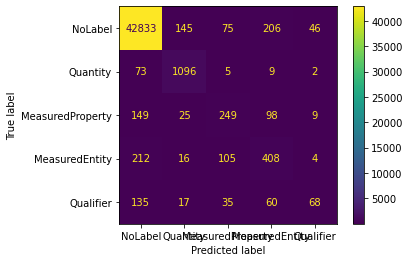

In [38]:
display_labels = list(task_map.keys())
display_labels.insert(0,str('NoLabel'))
cm = confusion_matrix(ytrue,ypred)
print(cm)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels).plot()
plt.show()

In [39]:
def tabulate_metrics(reports):
    metrics = []
    for epoch in reports:
        # print(epoch)
        epoch_metrics = {}
        for task, rpt in task_map.items():
            for metric, value in epoch[task].items():
                epoch_metrics[str(task+'_'+metric)] = value
        metrics.append(epoch_metrics)

    metrics = pd.DataFrame.from_dict(metrics)
    metrics.index.rename('epoch')
    return metrics

In [40]:
train_set_metrics = tabulate_metrics(run_report['eval_train_rpt'])
train_set_metrics

,Quantity_precision,Quantity_recall,Quantity_f1-score,Quantity_support,MeasuredProperty_precision,MeasuredProperty_recall,MeasuredProperty_f1-score,MeasuredProperty_support,MeasuredEntity_precision,MeasuredEntity_recall,MeasuredEntity_f1-score,MeasuredEntity_support,Qualifier_precision,Qualifier_recall,Qualifier_f1-score,Qualifier_support
0,0.726627,0.892545,0.801085,4467,0.000000,0.000000,0.000000,1707,0.578947,0.003409,0.006778,3227,0.000000,0.000000,0.000000,1286
1,0.872340,0.954556,0.911598,4467,0.532271,0.391330,0.451047,1707,0.572028,0.506972,0.537539,3227,0.500000,0.000778,0.001553,1286
2,0.928050,0.938437,0.933215,4467,0.640351,0.427651,0.512821,1707,0.657637,0.436319,0.524590,3227,0.764706,0.020218,0.039394,1286
3,0.905762,0.974703,0.938969,4467,0.607873,0.696544,0.649195,1707,0.701610,0.661605,0.681021,3227,0.796491,0.176516,0.288988,1286
4,0.940167,0.981419,0.960350,4467,0.645040,0.803749,0.715702,1707,0.780447,0.724822,0.751607,3227,0.853211,0.361586,0.507919,1286
5,0.939826,0.989478,0.964013,4467,0.650240,0.873462,0.745500,1707,0.764123,0.813139,0.787870,3227,0.787166,0.572317,0.662765,1286
6,0.954614,0.988807,0.971410,4467,0.728203,0.875806,0.795213,1707,0.870699,0.776263,0.820773,3227,0.900846,0.579316,0.705159,1286
7,0.974574,0.986792,0.980645,4467,0.801729,0.869361,0.834177,1707,0.861929,0.853114,0.857499,3227,0.932373,0.653966,0.768739,1286
8,0.978492,0.987911,0.983179,4467,0.832121,0.871119,0.851173,1707,0.858220,0.881624,0.869765,3227,0.894231,0.723173,0.799656,1286
9,0.979592,0.988583,0.984067,4467,0.825619,0.898653,0.860589,1707,0.874499,0.878835,0.876662,3227,0.908046,0.737170,0.813734,1286


In [41]:
dev_set_metrics = tabulate_metrics(run_report['eval_dev_rpt'])
dev_set_metrics

,Quantity_precision,Quantity_recall,Quantity_f1-score,Quantity_support,MeasuredProperty_precision,MeasuredProperty_recall,MeasuredProperty_f1-score,MeasuredProperty_support,MeasuredEntity_precision,MeasuredEntity_recall,MeasuredEntity_f1-score,MeasuredEntity_support,Qualifier_precision,Qualifier_recall,Qualifier_f1-score,Qualifier_support
0,0.698305,0.869198,0.774436,1185,0.000000,0.000000,0.000000,530,0.500000,0.001342,0.002677,745,0.000000,0.000000,0.000000,315
1,0.810230,0.922363,0.862668,1185,0.485531,0.284906,0.359096,530,0.428333,0.344966,0.382156,745,0.000000,0.000000,0.000000,315
2,0.882799,0.883544,0.883172,1185,0.572954,0.303774,0.397041,530,0.491018,0.220134,0.303985,745,0.333333,0.009524,0.018519,315
3,0.830174,0.924051,0.874601,1185,0.508584,0.447170,0.475904,530,0.475432,0.480537,0.477971,745,0.609756,0.079365,0.140449,315
4,0.853261,0.927426,0.888799,1185,0.512146,0.477358,0.494141,530,0.515942,0.477852,0.496167,745,0.626866,0.133333,0.219895,315
5,0.818713,0.945148,0.877399,1185,0.464286,0.515094,0.488372,530,0.470787,0.562416,0.512538,745,0.571429,0.253968,0.351648,315
6,0.838369,0.936709,0.884815,1185,0.508637,0.500000,0.504282,530,0.576182,0.441611,0.500000,745,0.611111,0.139683,0.227390,315
7,0.858156,0.918987,0.887531,1185,0.526652,0.466038,0.494494,530,0.529015,0.526174,0.527591,745,0.593023,0.161905,0.254364,315
8,0.841294,0.921519,0.879581,1185,0.539683,0.449057,0.490216,530,0.518972,0.569128,0.542894,745,0.489362,0.219048,0.302632,315
9,0.843726,0.924895,0.882448,1185,0.530917,0.469811,0.498498,530,0.522407,0.547651,0.534731,745,0.527132,0.215873,0.306306,315


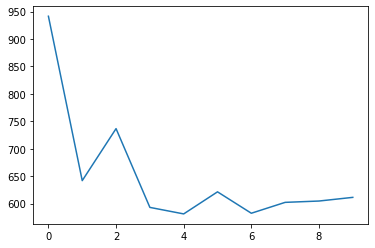

In [42]:
########################## loss plot #######################

import matplotlib.pyplot as plt
x = np.array(range(len(run_report['epoch'])))
y = np.array(run_report['eval_dev_loss'])
plt.plot(x,y)
plt.show()

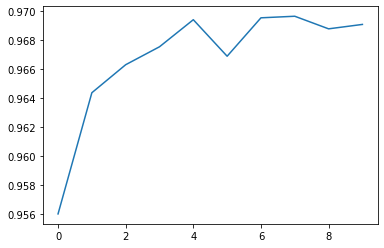

In [43]:
########################## accuracy plot #######################

import matplotlib.pyplot as plt
x = np.array(range(len(run_report['epoch'])))
y = np.array(run_report['eval_dev_acc'])
plt.plot(x,y)
plt.show()